        gp    wx    wy    gh       wvl  nmeta        T1        T2    phase1  \
0     0.70  0.30  0.60   1.0  1.500000  1.552  1.206929  1.398488  0.532642   
1     0.70  0.30  0.60   1.0  1.442308  1.552  1.082670  1.225317  1.985573   
2     0.70  0.30  0.60   1.0  1.388889  1.552  1.011937  1.113180 -2.840876   
3     0.70  0.30  0.60   1.0  1.339286  1.552  0.956835  1.029413 -1.384738   
4     0.70  0.30  0.60   1.0  1.293103  1.552  0.901455  0.958254  0.061871   
...    ...   ...   ...   ...       ...    ...       ...       ...       ...   
5962  1.25  0.39  0.78  20.0  0.528169  1.552  0.085838  0.341500 -0.864962   
5963  1.25  0.39  0.78  20.0  0.520833  1.552  0.292042  0.428587 -2.504840   
5964  1.25  0.39  0.78  20.0  0.513699  1.552  0.555291  0.214731  2.915933   
5965  1.25  0.39  0.78  20.0  0.506757  1.552  0.299737  0.179567  2.022971   
5966  1.25  0.39  0.78  20.0  0.500000  1.552  0.159264  0.320006 -0.081933   

        phasen    phase2  phasediff  
0    -2.60895

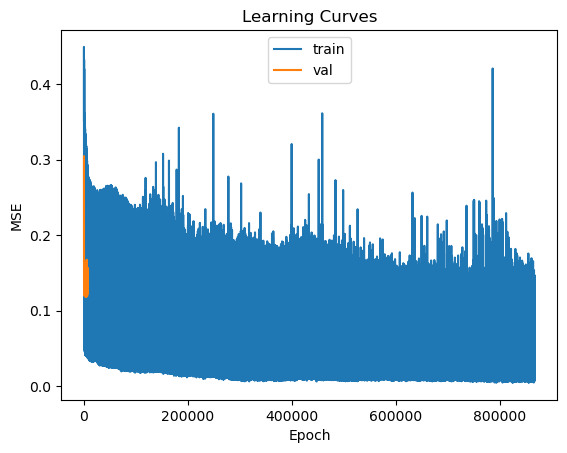

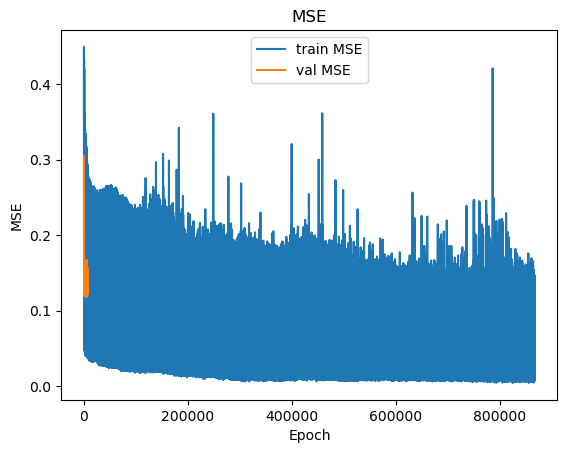

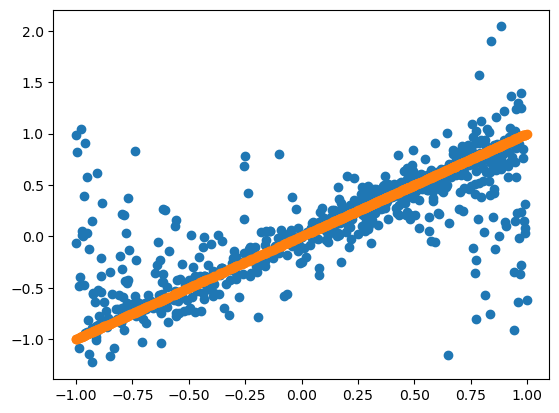

MSE: 0.1323


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 17 10:56:10 2021

@author: jisha
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

    
class MyModel(nn.Module):
    def __init__(self, n_features, n_outputs):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, n_outputs)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

dfm = pd.read_pickle('data_metasurface-low_index') 

print (dfm)

# Scale the input data in the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(dfm)
df_scaler = scaler.transform(dfm)

# input and output are defined. first three columns are input, and the 4th is output
# 10% of data is stored as a test dataset
X, y = df_scaler[:, 0:6], df_scaler[:, 11:12]
from sklearn.utils import shuffle
X, y = shuffle(X, y)
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.13)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32) 
y_test = torch.tensor(y_test, dtype=torch.float32)

# Determine the number of input features and output dimensions
n_features = X_train.shape[1]
n_outputs = y.shape[1]

# Create the model
model = MyModel(n_features, n_outputs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

##

# Evaluate the model on the test dataset
with torch.no_grad():
    model.eval()
    yhat_test = model(X_test)
    test_loss = criterion(yhat_test, y_test)

print('MSE Loss on Test Dataset:', test_loss.item())


train_losses = []
train_metrics = []
val_losses = []
val_metrics = [] 



# Training loop
num_epochs = 7000
batch_size = 42
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        val_loss = criterion(outputs, y_test)
        val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
        
        


# Save the model
torch.save(model.state_dict(), 'saved_model/my_model.pt') 



# Plot learning curves
plt.figure()
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.savefig('MLoss1.png')
plt.show()

# Plot MSE curve
plt.figure()
plt.title('MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(train_losses, label='train MSE')
plt.plot(val_losses, label='val MSE')
plt.legend()
plt.show()



# Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Plot y_pred vs y_test
plt.figure()
plt.scatter(y_test[:, -1], y_pred[:, -1])
plt.scatter(y_test[:, -1], y_test[:, -1])
plt.show()

# Calculate MSE manually
mse = criterion(y_pred, y_test)
print('MSE: %.4f' % mse.item())
      

    